In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision

In [2]:
transform = transforms.ToTensor()

dataset = datasets.FashionMNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = transform)

train_loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 100,
                                     shuffle = True)
dataset2 = datasets.FashionMNIST(root = "./data",
                         train = False,
                         download = True,
                         transform = transform)
test_loader = torch.utils.data.DataLoader(dataset = dataset2,
                                     batch_size = 100,
                                     shuffle = True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


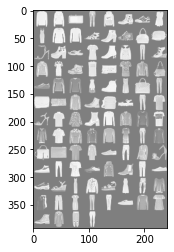

In [3]:



def imshow(img):
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()
dataiter = iter(train_loader)
images,labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))


In [4]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print(torch.min(images),torch.max(images))

tensor(0.) tensor(1.)


In [5]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder= nn.Sequential(
        nn.Conv2d(1,16,3,stride=2,padding=1),
        nn.ReLU(),
        nn.Conv2d(16,32,3,stride=2,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,5),
        nn.ReLU()        
    )
    self.decoder=nn.Sequential(
        nn.ConvTranspose2d(64,32,5),
        nn.ReLU(),
        nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16,1,3,stride=2,padding=1,output_padding=1),
        nn.Sigmoid()

    )
  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [6]:
model = Autoencoder()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-5)

In [21]:
def add_noise(img):
  noise_factor = 0.3
  noise_img = img + torch.randn_like(img)*noise_factor
  noise_img = torch.clip(noise_img,0.,1.)
  return noise_img


Epoch : 1, loss : 0.03645 
Epoch : 2, loss : 0.01852 
Epoch : 3, loss : 0.01667 
Epoch : 4, loss : 0.01583 
Epoch : 5, loss : 0.01530 


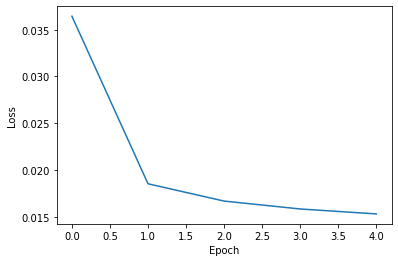

In [8]:
running_loss = 0
losses = []
l = len(train_loader)
for epoch in range(5):
  for (img,_) in train_loader:
    noisy_img = add_noise(img)
    reconstruction = model(noisy_img)
    loss = loss_function(reconstruction,img)
    optimizer.zero_grad()
    loss.backward()
    running_loss += loss.item()
    optimizer.step()
  losses.append(running_loss/l)
  print(f"Epoch : {epoch+1}, loss : {losses[epoch]:.5f} ")
  running_loss = 0
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)

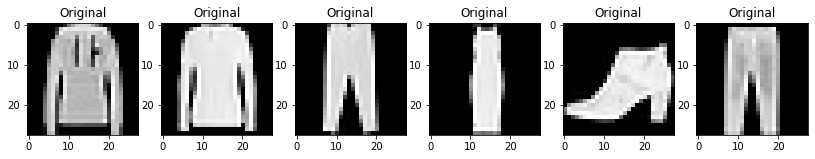

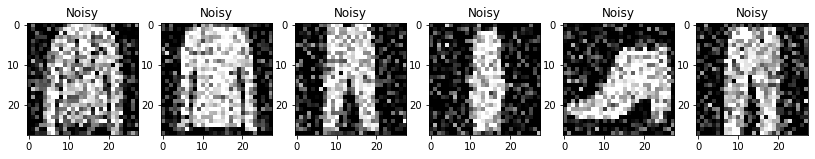

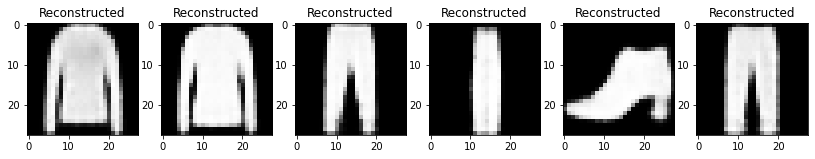

In [26]:
outputs = {}
img, _ = list(test_loader)[-3] 
out = model(img)
plt.figure(figsize=(14, 4))
outputs['img'] = add_noise(img)
outputs['out'] = out
outputs['Original_img'] = img
for i in range(6):
	val = outputs['Original_img']
	plt.subplot(1,6,i+1)
	plt.title("Original")
	plt.imshow(val[i].reshape(28,28),cmap='gray')
plt.show()
plt.figure(figsize=(14, 4))
counter = 1
for i in range(6):
	val = outputs['img']
	plt.subplot(1, 6, i+1)
	plt.title("Noisy")
	plt.imshow(val[i].reshape(28, 28), cmap='gray')
	counter += 1
plt.show()
plt.figure(figsize=(14, 4))
val = outputs['out'].detach().numpy()
for i in range(6):
	plt.subplot(1, 6, i+1)
	plt.title("Reconstructed")
	plt.imshow(val[i].reshape(28, 28), cmap='gray')
	# plt.figure(figsize=(18, 5))
	counter += 1
  
plt.show()